# Speaker Modelling: Single Driver, Ported vs. Closed Enclosure 

Originally written in MatLab, moved to Python when I graduated and my student liscense expired.

In [1]:
# Imports
import numpy as np
import math
from matplotlib import pyplot as plt

In [2]:
# Physical constants
rho = 1.2                             # density of air [kg/m^3]
co = 344                              # speed of sound in air [m/s] @ room temp/sea level
Zo = rho*co                           # characteristic specific acoustic impedance

In [3]:
# Driver characteristics (from driver spec sheet): 
diam = 0.107                          # diameter of the driver
Ad = np.pi * diam * diam / 4          # cross sectional area of the driver
a = diam/2

m = 0.009                             # moving mass is 9 grams
Cm = 740e-6                           # compliance in meters / Newton
omres_driver = math.sqrt(1/(m*Cm))    # mech resonance of driver
fres_driver = 1/(2*np.pi) * omres_driver 
Qfact = 2.21                          # quality factor of resonance for driver
Rm = omres_driver * m/Qfact           # obtaining Rm from Qfact 

Vs = 2.83                             # RMS voltage

BL = 5.9                              # BL constant for the driver system
Re = 6                                # resistance in ohms
L = 0.27e-3                           # inductance in Henry

In [4]:
# Enclosure characteristics:
Vencl = 0.0638                        # enclosed volume in m^2

Ca = Vencl / (Zo * co)                # acoustic compliance
Zarp = 885
Zard = 885
Rap_br = 0                            # Ported cabinet
Rap_cl = 1e9                          # Closed cabinet
Rap = Rap_br
ma = 35.21

In [5]:
# Computes parallel impedance: usually I have this in a file in my MatLab includes
def Zpar2(Z_1,Z_2): 

    return ((Z_1*Z_2)/(Z_1+Z_2))

In [6]:
# Set up simulation variables
f = np.logspace(0,3,500)                  # Frequency space
f_len = len(f)                            # 500 points
Qd = np.zeros((f_len, 1),dtype=complex)   # Volume velocities
Qp = np.zeros((f_len, 1),dtype=complex)
Qtot = np.zeros((f_len, 1),dtype=complex)
P = np.zeros((f_len, 1), dtype=complex)   # Pressure
i = np.array([1j], dtype=complex)         # The imaginary number

In [7]:
# Model speaker response at each frequency
for n in range(f_len):
    
    om = 2*np.pi*f[n]
    i_om = np.multiply(i, om)                  # Multiply preemptively because frequently used
    
    F = BL*Vs / (Re + i_om*L)                  # Applied signal to driver

    Pd = F / Ad;                               # Driver pressure = force/area
    
    # From mechanical model of driver:
    Zmd = Rm + i_om*m + 1/(i_om*Cm) + Zpar2((BL*BL/L)/i_om , (BL*BL/Re))
    
    # From redrawn network:
    Z1 = Zard + Zmd / (Ad*Ad)                  
    Z2 = Zarp + Rap + i_om*ma
    Z3 = 1/(i_om*Ca)
    
    # Set of system of equations:
    Z1_3 = Z1 + Z3
    Z1_2 = Z1 + Z2
    Z_MAT = np.squeeze(np.array([[Z1_3, Z1], [Z1, Z1_2]])) # Squeeze out arbitrary 3rd dimension 
    P_MAT = np.squeeze(np.array([[Pd],[Pd]]), axis=2)      #       (or linalg throw a fit later)
    
    # mldivide in MATLAB: Q_MAT = Z_MAT \ P_MAT;
    # NumPy's alternatives arent as good as MatLab's implementation, but they should work
    Q_MAT = np.linalg.lstsq(Z_MAT, P_MAT, rcond=-1)[0]

    # Find volume velocities:
    Qd[n] = np.add(Q_MAT[0], Q_MAT[1])          # Flow through diaphram
    Qp[n] = np.multiply(Q_MAT[1], -1)           # Flow through port

    Qtot[n] = Qd[n] + Qp[n]                     # Total flow

    P[n] = (i_om * rho * Qtot[n]) / (4*np.pi)   # Pressure (from flow)

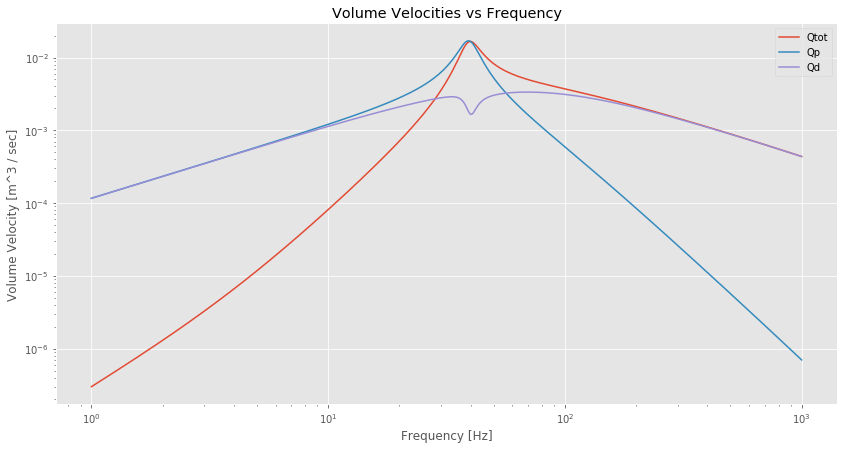

In [8]:
# Plot Volume Velocities
with plt.style.context('ggplot'): # Set style to be like R
    
    plt.figure(figsize=(14,7))
    plt.title('Volume Velocities vs Frequency')
    p1 = plt.loglog(f,abs(Qtot))
    p2 = plt.loglog(f,abs(Qp))
    p3 = plt.loglog(f,abs(Qd))
    plt.ylabel('Volume Velocity [m^3 / sec]') 
    plt.xlabel('Frequency [Hz]') 
    plt.legend(['Qtot', 'Qp', 'Qd'])
    
    
    # Style stuff below
    font = {'family': 'sans',
           'color':  'black',
           'weight': 'normal',
           'size': 16,
           }

In [9]:
# Calculate SPL for closed and ported cabinet
SPL_br = 20 * np.log10(np.divide(abs(P), (20e-6))) # Bass Reflex SPL (Ported)

SPL_closed = 20 * np.log10(np.divide(abs(P), 20e-6)) # Closed SPL 

# TODO: add easier way of switching between modelling ported/unported: function, add a main?

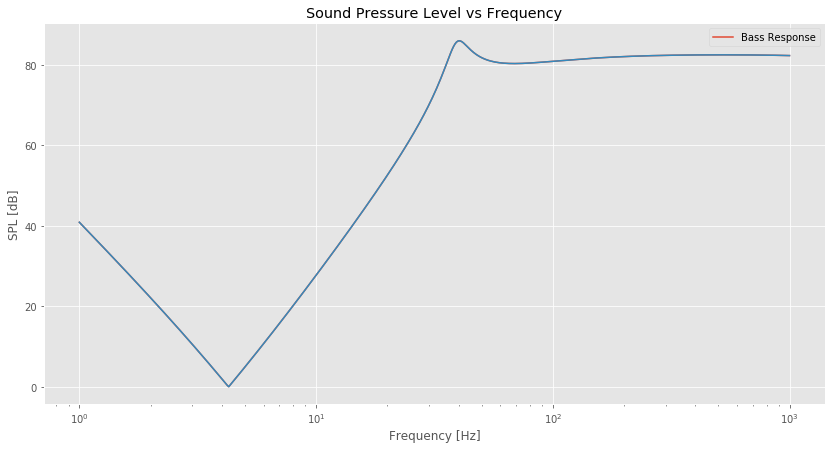

In [10]:
# Plot SPL
with plt.style.context('ggplot'): # Set style to be like R
    
    plt.figure(figsize=(14,7))
    plt.title('Sound Pressure Level vs Frequency')
    p1 = plt.semilogx(f,abs(SPL_br))
   # p2 = plt.semilogx(f,abs(SPL_closed))
    plt.ylabel('SPL [dB]') 
    plt.xlabel('Frequency [Hz]') 
    plt.legend(['Bass Response'])
    
    xlim=(1, 20000)
    
    # Style stuff below
    font = {'family': 'sans',
           'color':  'black',
           'weight': 'normal',
           'size': 16,
           }